In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)


In [7]:
paths = pd.read_csv('../paths.csv', index_col=0)

# Load full MAE embeddings dataset
embeddings_path = paths.loc["embeddings"].iloc[0] + "embeddings_cls.csv"
data = pd.read_csv(embeddings_path)

# Drop rows with missing age
data = data.dropna(subset=['age'])

# Feature columns
feature_cols = [f'feature_{i}' for i in range(1025)]
X = data[feature_cols]
y = data['age']

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features.")

Loaded 73094 samples with 1025 features.


In [8]:
X = X.fillna(X.mean())

# Remove extreme outliers (z-score > 4)
from scipy.stats import zscore
z_scores = np.abs(zscore(X))
non_outliers = ~np.any(z_scores > 4, axis=1)
X = X[non_outliers]
y = y[non_outliers]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [5]:
model = ElasticNetCV(
    cv=5,
    random_state=42,
    max_iter=10000,
    n_alphas=50,
    l1_ratio=0.9
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

/meta/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.824680398684, tolerance: 264.99606222263276
  model = cd_fast.enet_coordinate_descent_gram(
/meta/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 679.4488937006099, tolerance: 264.99606222263276
  model = cd_fast.enet_coordinate_descent_gram(
/meta/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350.3152215699665, tolerance: 264.99606222263276
  model = cd_fast.enet_coordinate_descent_gram(
/meta/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coo

Best alpha: 0.0046
R² on test set: 0.751
MAE on test set: 3.14 years


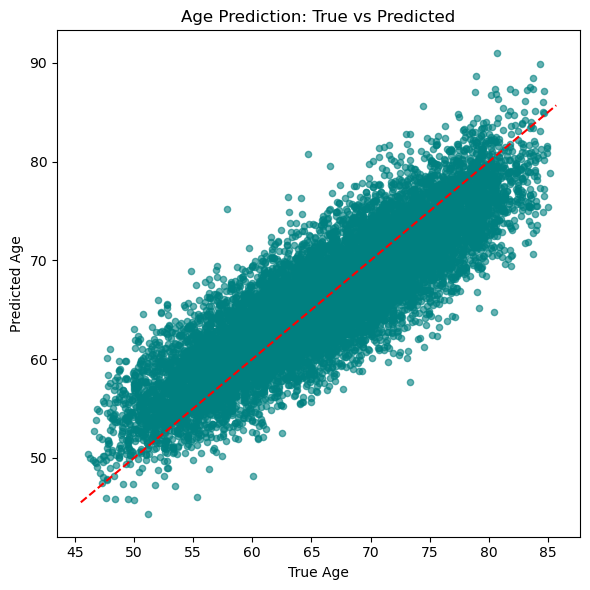

In [6]:
print(f"Best alpha: {model.alpha_:.4f}")
print(f"R² on test set: {r2_score(y_test, y_pred):.3f}")
print(f"MAE on test set: {mean_absolute_error(y_test, y_pred):.2f} years")

# Scatter plot: True vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, s=20, c='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("Age Prediction: True vs Predicted")
plt.tight_layout()
plt.show()

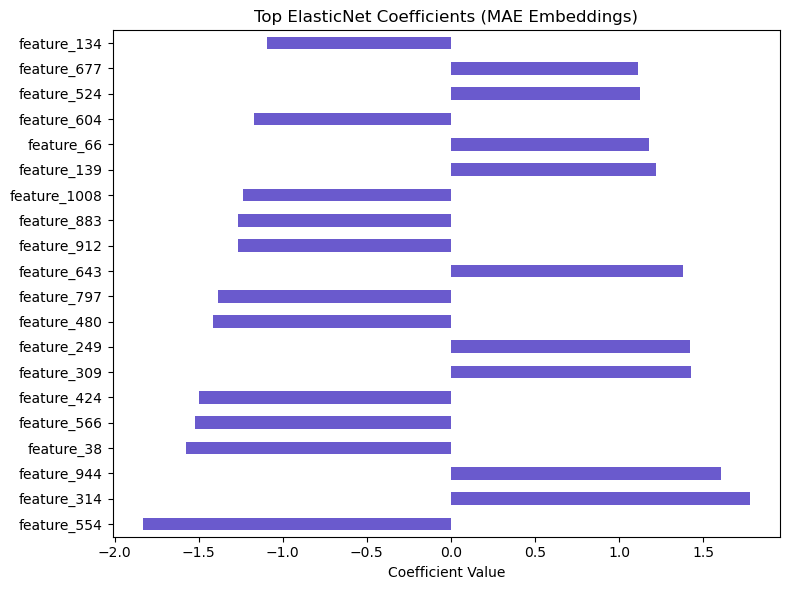

In [7]:
coef_df = pd.Series(model.coef_, index=feature_cols)
top_features = coef_df[coef_df != 0].sort_values(key=np.abs, ascending=False).head(20)

# Plot top coefficients
top_features.plot(kind='barh', figsize=(8, 6), color='slateblue')
plt.title("Top ElasticNet Coefficients (MAE Embeddings)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print("R² RF:", r2_score(y_test, y_rf))
print("MAE RF:", mean_absolute_error(y_test, y_rf))



R² RF: 0.6007033063804975
MAE RF: 3.972489874066273
